In [1]:
import glob
from torch.utils.data.dataset import Dataset 
from torchvision import transforms
from PIL import Image
import os.path as osp
import glob


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
#torch.cuda.set_device(2)
#device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt

In [5]:
# get all the image and mask path and number of images
folder_data = glob.glob("Gamma_noise_Data/clean/*.jpg")
folder_mask = glob.glob("Gamma_noise_Data//gamma_noise_celeb/*.jpg")

# split these path using a certain percentage
len_data = len(folder_data)

train_size = 0.8

train_image_paths = folder_data[:int(len_data*train_size)]
test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask[:int(len_data*train_size)]
test_mask_paths = folder_mask[int(len_data*train_size):]


class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):# initial logic happens like transform
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [6]:
print(len(test_dataset))
print(len(train_dataset))

2000
8000


In [7]:
train_dataloader= iter(train_loader)
sample = next(train_dataloader)

In [8]:
from matplotlib import pyplot

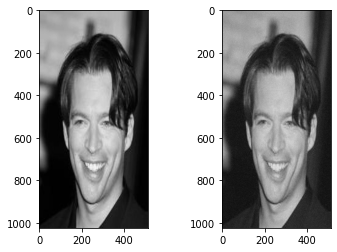

In [9]:
pyplot.subplot(1,2,1)
pyplot.imshow(sample[0][0][0,:,:],cmap='gray')
pyplot.subplot(1,2,2)
pyplot.imshow(sample[1][0][0,:,:],cmap='gray')
pyplot.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_prototyping as util

# net = Net()
net = util.Unet(in_channels=1,
                 out_channels=1,
                 nf0=32,
                 num_down=5,
                 max_channels=512,
                 use_dropout=True,
                 upsampling_mode='transpose',
                 dropout_prob=0.2,
                 norm=nn.BatchNorm2d,
                 outermost_linear=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

3
2
1
0


Unet(
  (in_layer): Sequential(
    (0): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      )
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (unet_block): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): DownBlock(
        (net): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Dropout2d(p=0.2, inplace=False)
          (5): ReflectionPad2d((1, 1, 1, 1))
          (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
          (7): BatchNorm2d(64, eps=1e-05, mo

In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.001)

In [12]:
%%time
for epoch in range(50):
    # loop over the dataset multiple times
    running_loss = 0.0
    train_dataloader= iter(train_loader)
    for i, data in enumerate(train_dataloader, 0):
        clean_inputs, noise_inputs = data
        clean_inputs, noise_inputs = clean_inputs.cuda(),noise_inputs.cuda()
        
        optimizer.zero_grad()
#         # forward + backward + optimize
        outputs = net(noise_inputs)
        outputs = torch.clamp(outputs/2 + .5, 0, 1)
        loss = criterion(outputs, clean_inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.02559
[1,  1000] loss: 0.01427
[1,  1500] loss: 0.01322
[1,  2000] loss: 0.01040
[1,  2500] loss: 0.00931
[1,  3000] loss: 0.00841
[1,  3500] loss: 0.00781
[1,  4000] loss: 0.00771
[1,  4500] loss: 0.00698
[1,  5000] loss: 0.00675
[1,  5500] loss: 0.00618
[1,  6000] loss: 0.00604
[1,  6500] loss: 0.00570
[1,  7000] loss: 0.00561
[1,  7500] loss: 0.00520
[1,  8000] loss: 0.00512
[2,   500] loss: 0.00534
[2,  1000] loss: 0.00522
[2,  1500] loss: 0.00482
[2,  2000] loss: 0.00447
[2,  2500] loss: 0.00429
[2,  3000] loss: 0.00476
[2,  3500] loss: 0.00478
[2,  4000] loss: 0.00440
[2,  4500] loss: 0.00474
[2,  5000] loss: 0.00470
[2,  5500] loss: 0.00443
[2,  6000] loss: 0.00457
[2,  6500] loss: 0.00437
[2,  7000] loss: 0.00392
[2,  7500] loss: 0.00456
[2,  8000] loss: 0.00397
[3,   500] loss: 0.00440
[3,  1000] loss: 0.00414
[3,  1500] loss: 0.00404
[3,  2000] loss: 0.00378
[3,  2500] loss: 0.00355
[3,  3000] loss: 0.00363
[3,  3500] loss: 0.00400
[3,  4000] loss: 0.00408


[21,  1000] loss: 0.00167
[21,  1500] loss: 0.00179
[21,  2000] loss: 0.00178
[21,  2500] loss: 0.00183
[21,  3000] loss: 0.00188
[21,  3500] loss: 0.00182
[21,  4000] loss: 0.00188
[21,  4500] loss: 0.00205
[21,  5000] loss: 0.00187
[21,  5500] loss: 0.00174
[21,  6000] loss: 0.00181
[21,  6500] loss: 0.00173
[21,  7000] loss: 0.00196
[21,  7500] loss: 0.00159
[21,  8000] loss: 0.00200
[22,   500] loss: 0.00168
[22,  1000] loss: 0.00171
[22,  1500] loss: 0.00187
[22,  2000] loss: 0.00172
[22,  2500] loss: 0.00180
[22,  3000] loss: 0.00193
[22,  3500] loss: 0.00185
[22,  4000] loss: 0.00175
[22,  4500] loss: 0.00190
[22,  5000] loss: 0.00196
[22,  5500] loss: 0.00184
[22,  6000] loss: 0.00160
[22,  6500] loss: 0.00169
[22,  7000] loss: 0.00184
[22,  7500] loss: 0.00170
[22,  8000] loss: 0.00181
[23,   500] loss: 0.00163
[23,  1000] loss: 0.00161
[23,  1500] loss: 0.00198
[23,  2000] loss: 0.00171
[23,  2500] loss: 0.00178
[23,  3000] loss: 0.00195
[23,  3500] loss: 0.00197
[23,  4000] 

[40,  7000] loss: 0.00149
[40,  7500] loss: 0.00143
[40,  8000] loss: 0.00155
[41,   500] loss: 0.00132
[41,  1000] loss: 0.00137
[41,  1500] loss: 0.00159
[41,  2000] loss: 0.00138
[41,  2500] loss: 0.00143
[41,  3000] loss: 0.00158
[41,  3500] loss: 0.00143
[41,  4000] loss: 0.00152
[41,  4500] loss: 0.00166
[41,  5000] loss: 0.00159
[41,  5500] loss: 0.00137
[41,  6000] loss: 0.00152
[41,  6500] loss: 0.00141
[41,  7000] loss: 0.00160
[41,  7500] loss: 0.00125
[41,  8000] loss: 0.00148
[42,   500] loss: 0.00141
[42,  1000] loss: 0.00145
[42,  1500] loss: 0.00141
[42,  2000] loss: 0.00137
[42,  2500] loss: 0.00144
[42,  3000] loss: 0.00162
[42,  3500] loss: 0.00156
[42,  4000] loss: 0.00167
[42,  4500] loss: 0.00168
[42,  5000] loss: 0.00152
[42,  5500] loss: 0.00152
[42,  6000] loss: 0.00139
[42,  6500] loss: 0.00152
[42,  7000] loss: 0.00159
[42,  7500] loss: 0.00129
[42,  8000] loss: 0.00153
[43,   500] loss: 0.00147
[43,  1000] loss: 0.00144
[43,  1500] loss: 0.00151
[43,  2000] 

In [13]:
torch.save(net.state_dict(), 'weights_only_gamma_noise.pth')

In [14]:
testdataloader = iter(test_loader)


In [15]:
sample = next(testdataloader)
clean_inputs, noise_inputs = sample
print(type(noise_inputs))
print(noise_inputs.shape)
clean_inputs, noise_inputs = clean_inputs.cpu(),noise_inputs.cuda()

<class 'torch.Tensor'>
torch.Size([1, 1, 1024, 512])


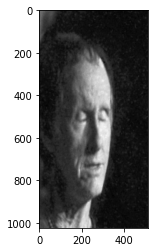

In [16]:
pred = net(noise_inputs)
plt.imshow(pred.detach().cpu()[0,0],cmap='gray')

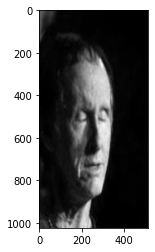

In [17]:
plt.imshow(clean_inputs.detach().cpu()[0,0],cmap='gray')
im1=clean_inputs.detach().cpu()[0,0]
#im1 = im1.save("geeks.jpg")

<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fec7e92fbd0>


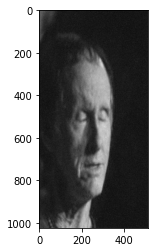

In [18]:
print(type(noise_inputs.cpu()[0,0]))
print(noise_inputs.cpu()[0,0].size)
plt.imshow(noise_inputs.detach().cpu()[0,0],cmap='gray')

In [19]:
# pred2 = net(noise_inputs)
# plt.imshow(pred2.detach().cpu()[0,0],cmap='gray')

In [20]:
from torchvision.utils import save_image
save_image(noise_inputs.cpu()[0,0], 'gamma_updated_noise.jpg')
save_image(clean_inputs.detach().cpu()[0,0], 'gamma_updated_clean.jpg')
save_image(pred.detach().cpu(), 'gamma_updated_predicted.jpg')


In [23]:
import cv2
im_clean=cv2.imread('gamma_updated_clean.jpg')
im_noisy=cv2.imread('gamma_updated_noise.jpg')
im_pred=cv2.imread('gamma_updated_predicted.jpg')

In [26]:
from skimage.metrics import structural_similarity as ssim
ssim_const = ssim(im_clean, im_pred,data_range=im_pred.max() - im_pred.min(),multichannel=True)

In [27]:
print(f"SSIM value for clean image and predicted image is {ssim_const}")

SSIM value for clean image and predicted image is 0.409124577562962


In [28]:
ssim_const1 = ssim(im_clean, im_noisy,data_range=im_noisy.max() - im_noisy.min(),multichannel=True)
print(f"SSIM value for clean image and noisy image is {ssim_const1}")

SSIM value for clean image and noisy image is 0.25239129088407986


In [29]:
import numpy as np
from math import log10, sqrt
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [30]:
value = PSNR(im_clean, im_pred)
print(f"PSNR value for clean image and predicted image is {value} dB")

PSNR value for clean image and predicted image is 30.693673568010183 dB


In [31]:
value1 = PSNR(im_clean, im_noisy)
print(f"PSNR value for clean image and nosiy image is {value1} dB")

PSNR value for clean image and nosiy image is 28.077521176138312 dB


In [32]:
Y = np.square(np.subtract(im_clean,im_pred)).mean()
print("MSE:", Y)

MSE: 55.42593193054199


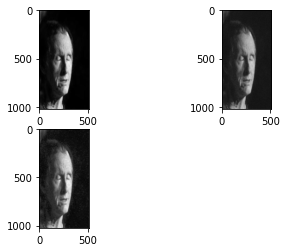

In [33]:
pyplot.subplot(2,2,1)
pyplot.imshow(clean_inputs.detach().cpu()[0,0],cmap='gray')
pyplot.subplot(2,2,2)
pyplot.imshow(noise_inputs.detach().cpu()[0,0],cmap='gray')
pyplot.subplot(2,2,3)
pyplot.imshow(pred.detach().cpu()[0,0],cmap='gray')
pyplot.show()

In [34]:
sample = next(testdataloader)
clean_inputs, noise_inputs = sample
print(type(noise_inputs))
print(noise_inputs.shape)
clean_inputs, noise_inputs = clean_inputs.cpu(),noise_inputs.cuda()

<class 'torch.Tensor'>
torch.Size([1, 1, 1024, 512])


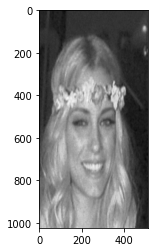

In [35]:
pred = net(noise_inputs)
plt.imshow(pred.detach().cpu()[0,0],cmap='gray')

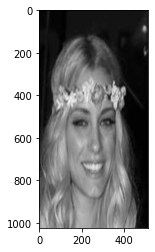

In [36]:
plt.imshow(clean_inputs.detach().cpu()[0,0],cmap='gray')
im1=clean_inputs.detach().cpu()[0,0]
#im1 = im1.save("geeks.jpg")

<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fec7e861f90>


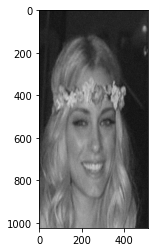

In [37]:
print(type(noise_inputs.cpu()[0,0]))
print(noise_inputs.cpu()[0,0].size)
plt.imshow(noise_inputs.detach().cpu()[0,0],cmap='gray')

In [38]:
from torchvision.utils import save_image
save_image(noise_inputs.cpu()[0,0], 'gamma_updated_noise2.jpg')
save_image(clean_inputs.detach().cpu()[0,0], 'gamma_updated_clean2.jpg')
save_image(pred.detach().cpu(), 'gamma_updated_predicted2.jpg')

im_clean2=cv2.imread('gamma_updated_clean2.jpg')
im_noisy2=cv2.imread('gamma_updated_noise2.jpg')
im_pred2=cv2.imread('gamma_updated_predicted2.jpg')

In [39]:
from skimage.metrics import structural_similarity as ssim
ssim_const = ssim(im_clean2, im_pred2,data_range=im_pred2.max() - im_pred2.min(),multichannel=True)
print(f"SSIM value for clean image and predicted image is {ssim_const}")
ssim_const1 = ssim(im_clean2, im_noisy2,data_range=im_noisy2.max() - im_noisy2.min(),multichannel=True)
print(f"SSIM value for clean image and noisy image is {ssim_const1}")

SSIM value for clean image and predicted image is 0.14392724838093673
SSIM value for clean image and noisy image is 0.44268449249432806


In [40]:
value = PSNR(im_clean2, im_pred2)
print(f"PSNR value for clean image and predicted image is {value} dB")

value1 = PSNR(im_clean2, im_noisy2)
print(f"PSNR value for clean image and nosiy image is {value1} dB")

PSNR value for clean image and predicted image is 28.23759370885208 dB
PSNR value for clean image and nosiy image is 28.685903089262013 dB


In [41]:
Y = np.square(np.subtract(im_clean,im_pred)).mean()
print("MSE:", Y)

MSE: 55.42593193054199


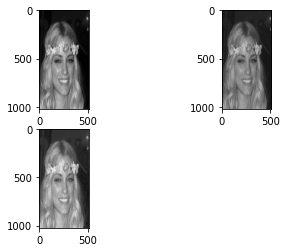

In [42]:
pyplot.subplot(2,2,1)
pyplot.imshow(clean_inputs.detach().cpu()[0,0],cmap='gray')
pyplot.subplot(2,2,2)
pyplot.imshow(noise_inputs.detach().cpu()[0,0],cmap='gray')
pyplot.subplot(2,2,3)
pyplot.imshow(pred.detach().cpu()[0,0],cmap='gray')
pyplot.show()